## SUM149 and SUM159 cell line analysis

**Author:Dr.Xi Li**

**Created: 01/06/2022**

**Language: Python**

This document serves to provide analysis to SUM149 and SUM159 data it takes as imput is a loom file extracted from velocyto and provides H5d5 for storage, as well as several figures and tables as output.


NOTE: cyto trace file must be present in the directory that this script is located in

In [1]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import scvelo as scv
import loompy as lp
import pandas as pd
import numpy as np
import os
import scanpy as sc
import scipy.stats as stats
from io import StringIO
from sklearn import linear_model
import seaborn as sns

%matplotlib inline

In [12]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')
# for beautified visualization


plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

## input sample path

First lets find the directory that we are working in

**Note:  SigsDir must be changed depending on the user to allow for proper use of this script**

In [13]:
os.getcwd()

'/mnt/c9b6130c-37e5-4f62-becc-dd4240b42021/T127_T22_ola_2'

In [14]:
#set directory to where signature gene lists locates
SigsDir="/mnt/533ee9c3-18c0-4c72-a09e-d9ce5a10ef9e/sig"
AnnoRefDir="/mnt/533ee9c3-18c0-4c72-a09e-d9ce5a10ef9e/T_anno_ref"

In [29]:
#set the directory for outputs
project_ID="pool_M1_M2_MKI67"
scv.settings.figdir=f'{project_ID}_figures'

In [30]:
RESOURCES_FOLDERNAME = "/mnt/533ee9c3-18c0-4c72-a09e-d9ce5a10ef9e/resources/"
AUXILLIARIES_FOLDERNAME = "/mnt/533ee9c3-18c0-4c72-a09e-d9ce5a10ef9e/auxilliaries/"
RESULTS_FOLDERNAME = f'{project_ID}_DEG/'
FIGURES_FOLDERNAME =f'{project_ID}_figures/'
sc.settings.figdir = FIGURES_FOLDERNAME

In [31]:
BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
COLUMN_NAME_LOGO = "MotifLogo"
COLUMN_NAME_MOTIF_ID = "MotifID"
COLUMN_NAME_TARGETS = "TargetGenes"

## Unique Gene Names

First we want to select the genes that we wish to look at and format them into a data frame that we can use later on

In [18]:
#set the directory for outputs
project_ID="pool_M1_M2_MKI67"
scv.settings.figdir=f'{project_ID}_figures'

In [19]:
adata=scv.read (f"{project_ID}_anno_dy_reg.h5ad")

In [422]:
Sample_idx=pd.Series("Unknown", index=adata.obs_names)
m=0
for i in np.unique(adata.obs.treatment):   
    Sample_idx[adata.obs.treatment==i]=m
    m=m+1
adata.obs["Sample_idx"]=Sample_idx.values
adata.obs["Sample_idx"]=adata.obs["Sample_idx"].astype(float)

In [423]:
#store a h5ad file for further faster loadinig
adata.var_names_make_unique("_")

#we need to make a directory to store the files in
try:
    directoryName=project_ID+"_figures"
    os.mkdir(directoryName)
except:
    pass

#we need to make a directory to store the files in
#we need to make a directory to store the files in
try:
    directoryName=project_ID+"_DEG"
    os.mkdir(directoryName)
except:
    pass


## Preprocess the Data

now we will take the files from the previous section where we determined spliced/unspliced RNA counts and use them to create RNA velocity trajectory as well as investigate biological alternation in each cell

In [64]:
#calculate the percentage of mitochondrial genes and ribosomal genes
adata.var['mt'] = adata.var_names.str.startswith('mt-')
adata.var['rp'] = adata.var_names.str.startswith('Rp')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata, qc_vars=['rp'], percent_top=None, log1p=False, inplace=True)
#sc.pl.violin(adata, ['n_vars'], groupby='Sample_ID', stripplot=False) 

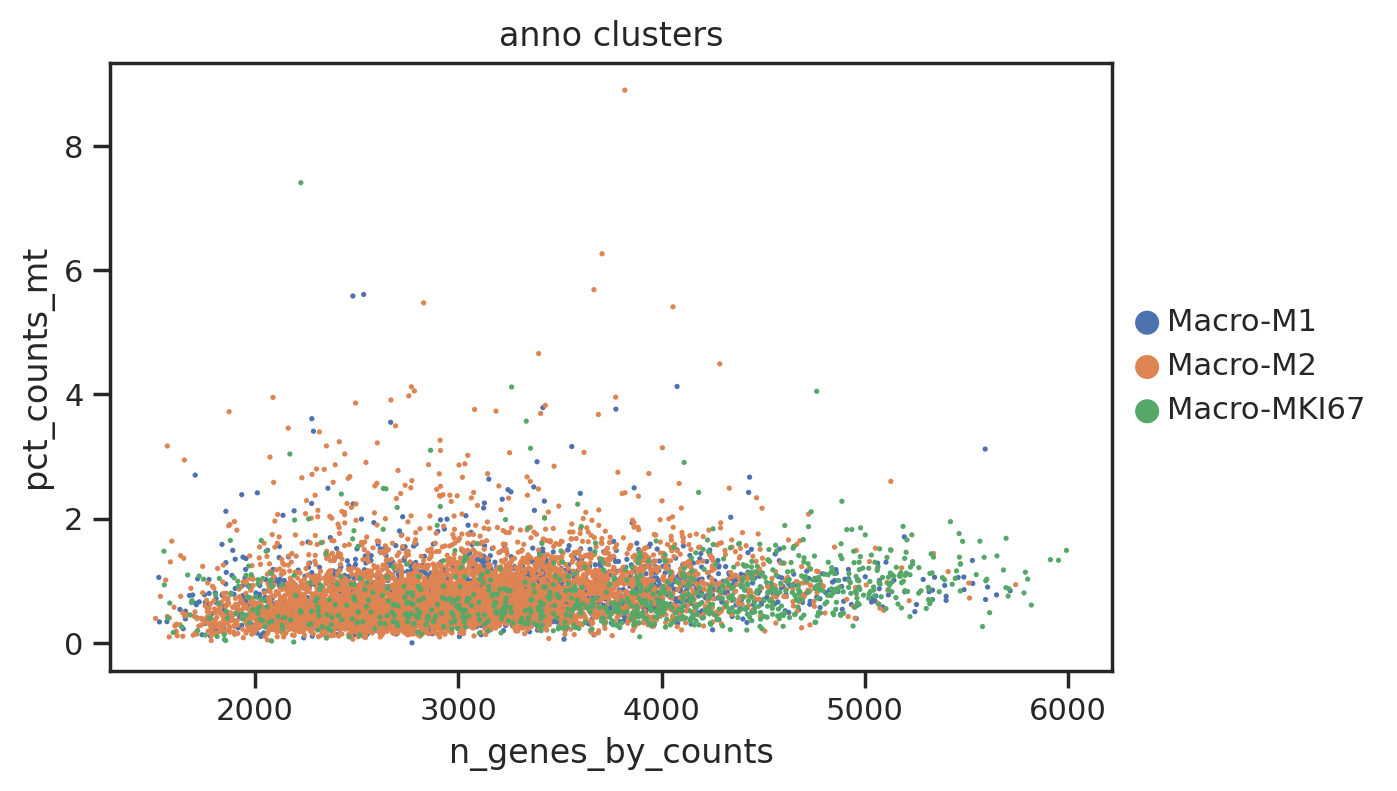

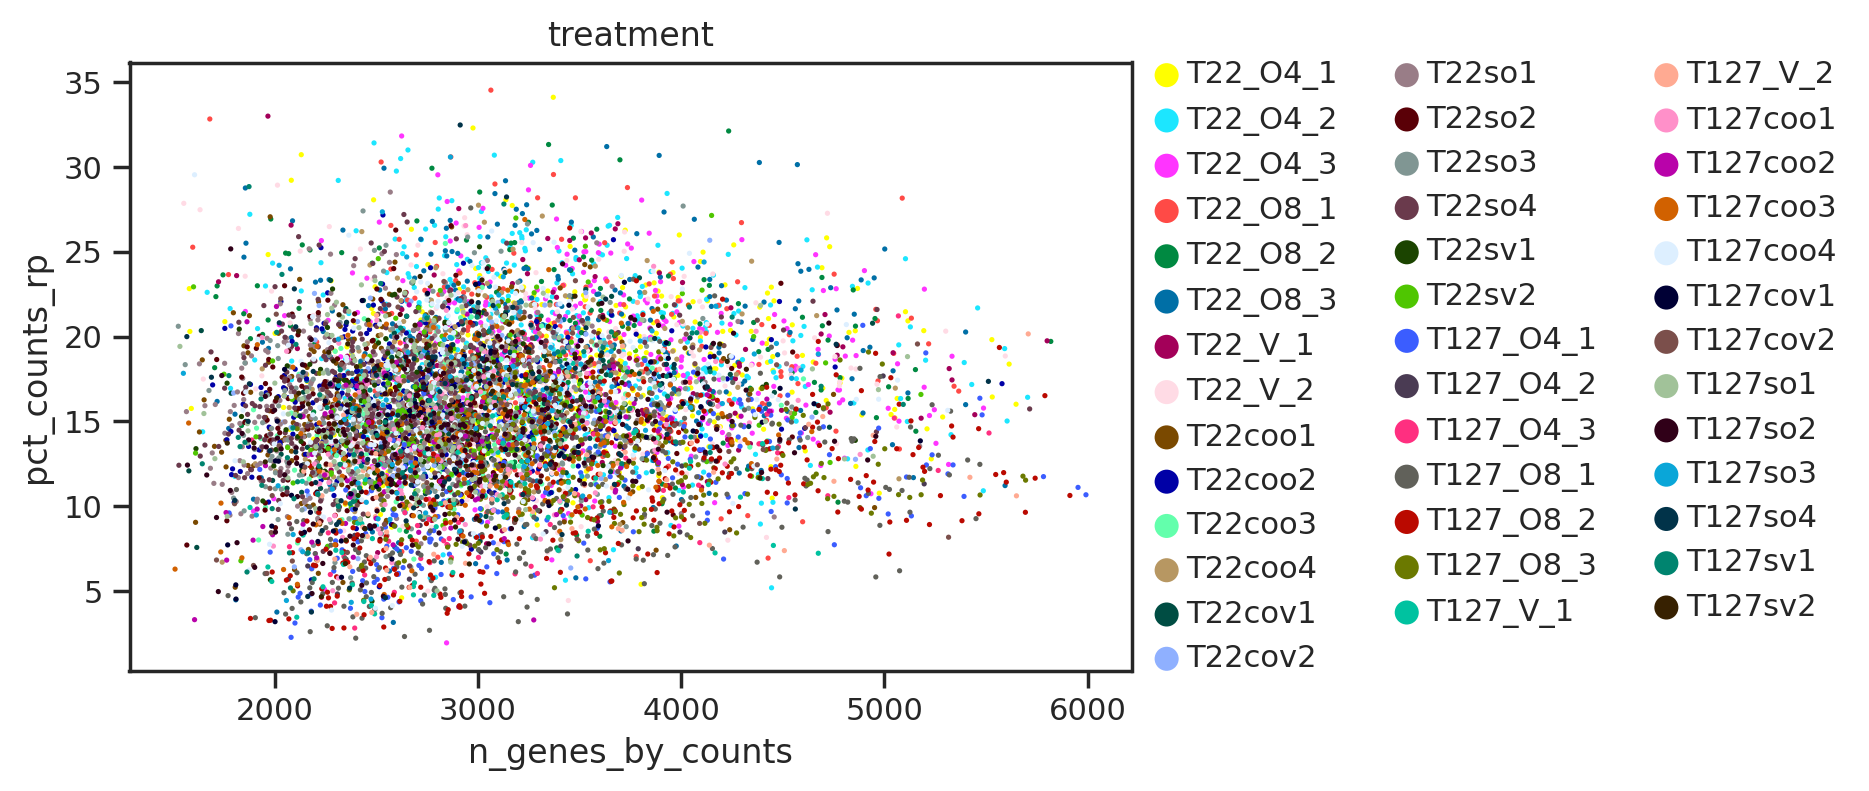

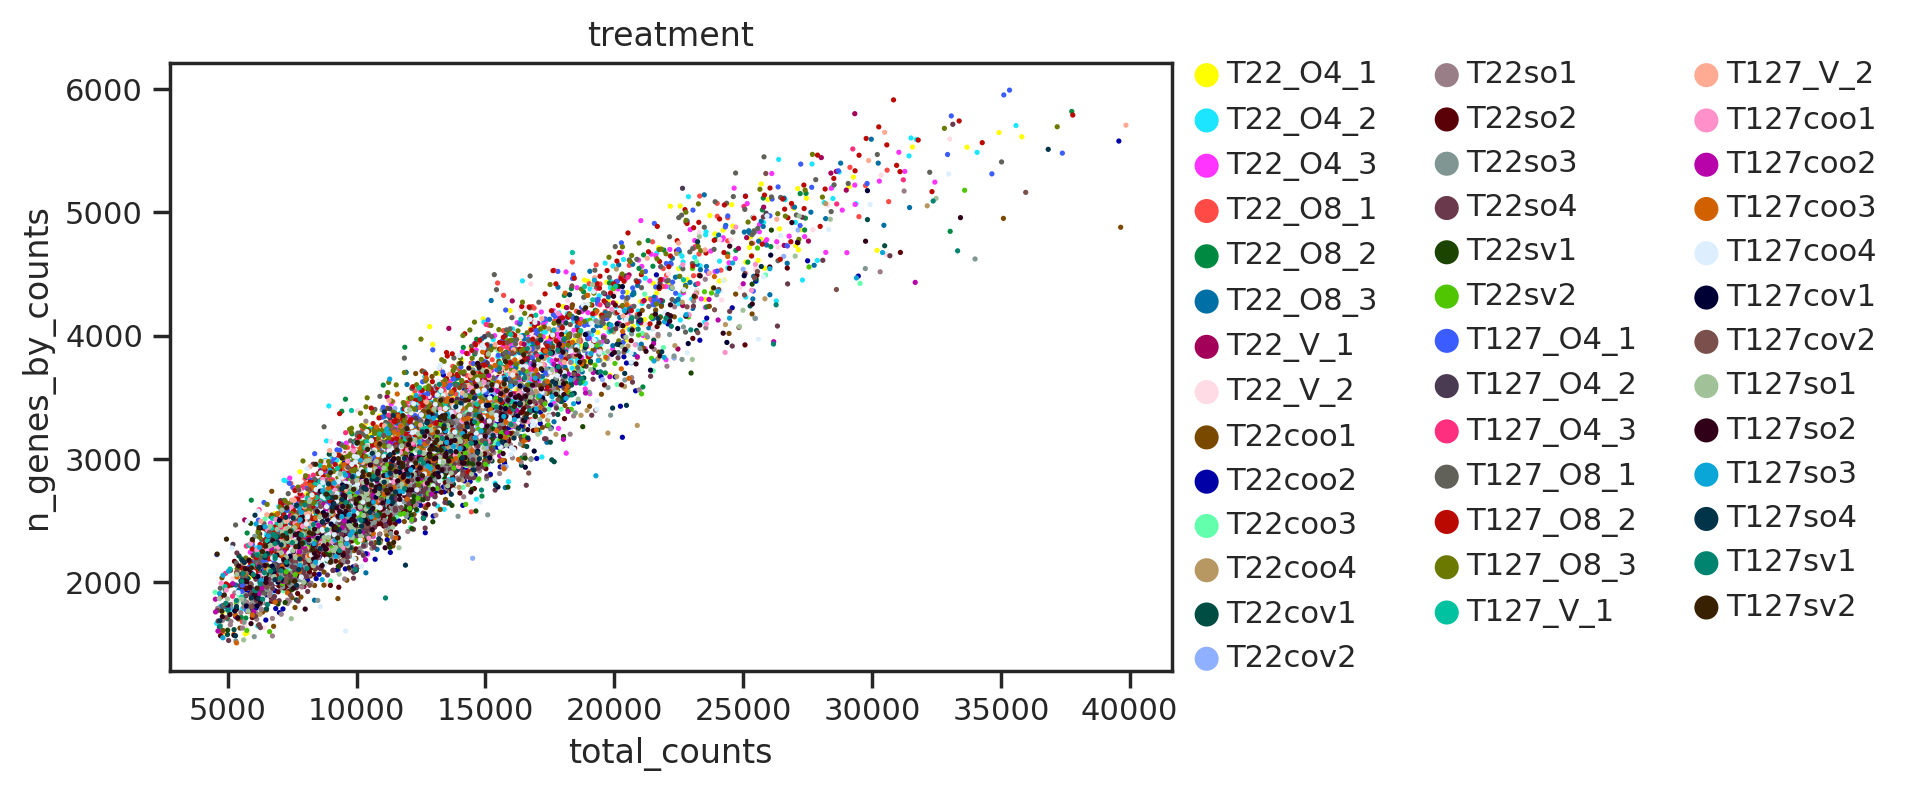

In [65]:
#plot scatter plots of dataset QC
sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_mt', color="anno_clusters",)
sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_rp', color="treatment",)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',color="treatment")


In [ ]:
matrix=adata.copy().T.to_df(layer="spliced")

***

**Continued data processing**

In [66]:
scv.pp.filter_and_normalize(adata, min_cells=0.1*(len(adata.to_df())), n_top_genes=4000,
                            flavor="cell_ranger")
scv.tl.score_genes_cell_cycle(adata, s_genes= ['Mcm5', 'Pcna', 'Tyms', 'Fen1', 'Mcm2', 'Mcm4', 'Rrm1', 'Ung', 'Gins2',
     'Mcm6', 'Cdca7', 'Dtl', 'Prim1', 'Uhrf1', 'Mlf1ip', 'Hells', 'Rfc2',
     'Rpa2', 'Nasp', 'Rad51ap1', 'Gmnn', 'Wdr76', 'Slbp', 'Ccne2', 'Ubr7',
     'Pold3', 'Msh2', 'Atad2', 'Rad51', 'Rrm2', 'Cdc45', 'Cdc6', 'Exo1', 'Tipin',
     'Dscc1', 'Blm', 'Casp8ap2', 'Usp1', 'Clspn', 'Pola1', 'Chaf1b', 'Brip1', 'E2f8'], g2m_genes = ['Hmgb2', 'Cdk1', 'Nusap1', 'Ube2c', 'Birc5', 'Tpx2', 'Top2a', 'Ndc80',
     'Cks2', 'Nuf2', 'Cks1b', 'Mki67', 'Tmpo', 'Cenpf', 'Tacc3', 'Fam64a',
     'Smc4', 'Ccnb2', 'Ckap2l', 'Ckap2', 'Aurkb', 'Bub1', 'Kif11', 'Anp32e',
     'Tubb4b', 'Gtse1', 'Kif20b', 'Hjurp', 'Cdca3', 'Hn1', 'Cdc20', 'Ttk',
     'Cdc25c', 'Kif2c', 'Rangap1', 'Ncapd2', 'Dlgap5', 'Cdca2', 'Cdca8',
     'Ect2', 'Kif23', 'Hmmr', 'Aurka', 'Psrc1', 'Anln', 'Lbr', 'Ckap5',
     'Cenpe', 'Ctcf', 'Nek2', 'G2e3', 'Gas2l3', 'Cbx5', 'Cenpa']) # calculate cell cycle score with scv internal function and its gene list of s phase and g2m phase, then we will have two observations---"S_score" and "G2M_score" added in adata 
sc.pp.regress_out(adata, keys=["total_counts","n_genes_by_counts","S_score","G2M_score","Sample_idx"] , n_jobs=None, copy=False) # we remove cell cycle effects
scv.pp.moments(adata,n_pcs=10, n_neighbors=150, mode="distances") # we calculate a moment matrix for further RNA velocity analysis

Filtered out 16975 genes that are detected in less than 10 cells (spliced).
Normalized count data: X, spliced, unspliced.


Logarithmized X.
calculating cell cycle phase


... storing 'phase' as categorical


-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)
computing neighbors
    finished (0:00:09) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on distances
    finished (0:00:15) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [67]:
#calculate umap
scv.tl.umap(adata, n_components=2, min_dist=0.7, spread=1, maxiter=None, alpha=1.0,
            gamma=1, negative_sample_rate=5, init_pos="spectral", random_state=0, a=None,
            b=None, copy=False, method="umap", neighbors_key=None)

In [68]:
#calculate louvain clusters based on the umap we generated previously
sc.tl.leiden(adata, resolution=5,  
                 key_added='leiden', use_weights=True)
adata.obs["clusters"]=adata.obs["leiden"]

In [ ]:
#check proportions of spliced and unspliced RNA in each cluster
scv.pl.proportions(adata)

saving figure to file pool_M1_M2_MKI67_figures/scvelo_anno_clusters_umap.pdf


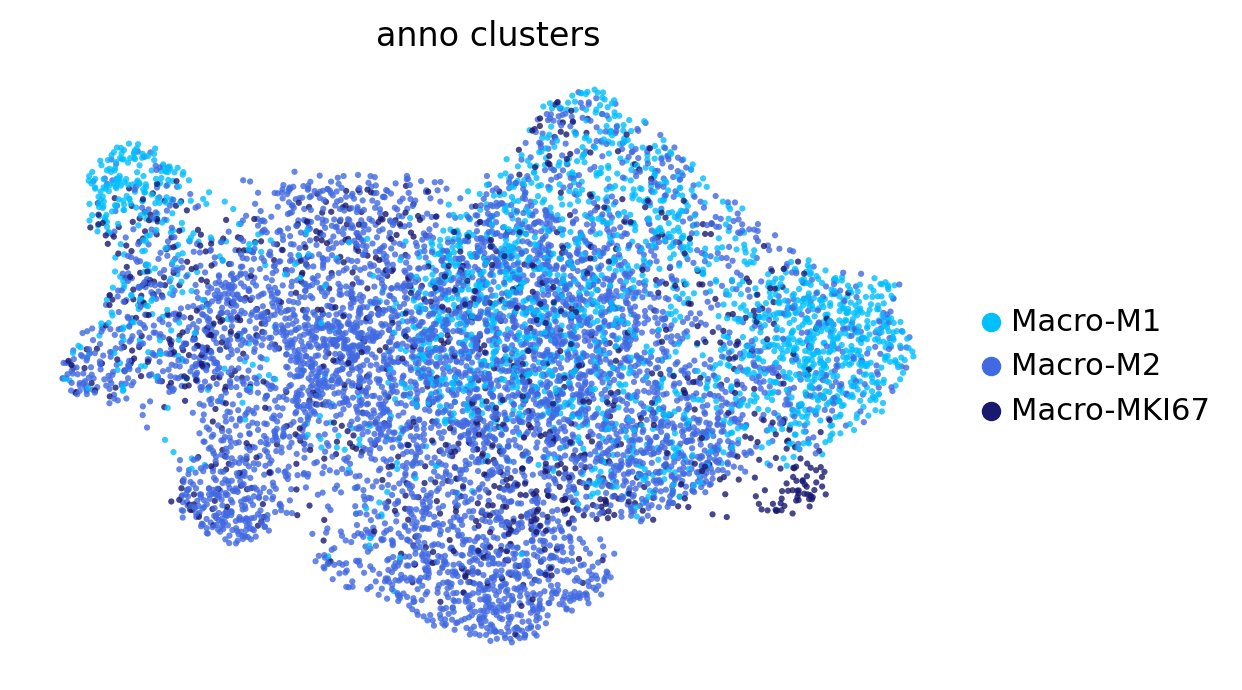

In [22]:
#plot umap grouped by treatment
plot_pattern="anno_clusters"
scv.pl.scatter(adata,save=f"{plot_pattern}_umap.pdf",
               basis="umap",
           color=plot_pattern,legend_loc="right",
          palette=[ "DeepSkyBlue","royalblue","MidnightBlue","Pink","hotpink","darkviolet",
                    "SpringGreen","forestgreen","maroon"
            ,"PapayaWhip", "gold","orchid","crimson"
            ,"firebrick","olivedrab","lightcoral","greenyellow"
            ,"tan","slategrey","coral","lightseagreen"
            ,"lightsteelblue","lightskyblue","dimgrey",
            "indigo","darkturquoise"],
            size=20, alpha=0.8,
            )

In [ ]:
#plot umap grouped by treatment
plot_pattern="treatment"
scv.pl.scatter(adata, save=f"{plot_pattern}_umap.pdf",
               basis="umap",
           color=plot_pattern,legend_loc="right",
          palette=[   "DeepSkyBlue","Pink","royalblue","MidnightBlue","DarkMagenta","hotpink","PeachPuff","darkviolet",
                    "SpringGreen","forestgreen","maroon","IndianRed","PaleVioletRed",
            "PapayaWhip", "gold","orchid","crimson","Sandybrown","mediumvioletred",
            "firebrick","olivedrab","lightcoral","greenyellow"
            ,"tan","slategrey","coral","lightseagreen","Aqua","CadetBlue","PaleTurquoise",
            "lightsteelblue","lightskyblue","dimgrey","RosyBrown","Goldenrod","BurlyWood","Peru",
            "indigo","Thistle","black"],
            size=20, alpha=0.8,
            )

In [2]:
import glob, re, pickle
from functools import partial
from collections import OrderedDict
import operator as op
from cytoolz import compose

from pyscenic.export import export2loom, add_scenic_metadata
from pyscenic.utils import load_motifs
from pyscenic.transform import df2regulons
from pyscenic.aucell import aucell
from pyscenic.binarization import binarize
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_binarization, plot_rss


from IPython.display import HTML, display
import matplotlib as mpl

In [3]:
import pyscenic
pyscenic.__version__

'0.11.2'

In [34]:
def savesvg(fname: str, fig, folder: str=FIGURES_FOLDERNAME) -> None:
    """
    Save figure as vector-based SVG image format.
    """
    fig.tight_layout()
    fig.savefig(os.path.join(folder, fname), format='svg')

In [35]:
def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
    """
    :param df:
    :param base_url:
    """
    # Make sure the original dataframe is not altered.
    df = df.copy()
    
    # Add column with URLs to sequence logo.
    def create_url(motif_id):
        return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
    df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
    # Truncate TargetGenes.
    def truncate(col_val):
        return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
    df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
    MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', -1)
    display(HTML(df.head().to_html(escape=False)))
    pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [36]:
# Downloaded fromm pySCENIC github repo: https://github.com/aertslab/pySCENIC/tree/master/resources
MM_TFS_FNAME = os.path.join(AUXILLIARIES_FOLDERNAME, 'mm_tfs.txt')
# Ranking databases. Downloaded from cisTargetDB: https://resources.aertslab.org/cistarget/
RANKING_DBS_FNAMES = list(map(lambda fn: os.path.join(AUXILLIARIES_FOLDERNAME, fn),
                       [
                       'mm10__refseq-r80__10kb_up_and_down_tss.mc9nr.feather',
                        'mm10__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr.feather']))
# Motif annotations. Downloaded from cisTargetDB: https://resources.aertslab.org/cistarget/
MOTIF_ANNOTATIONS_FNAME = os.path.join(AUXILLIARIES_FOLDERNAME, 'motifs-v9-nr.mgi-m0.001-o0.0.tbl')

In [37]:
DATASET_ID=project_ID

In [38]:
METADATA_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.metadata.csv'.format(DATASET_ID))
COUNTS_QC_MTX_FNAME = os.path.join(f"{project_ID}_DEG", 'matrix_raw.qc.counts.csv')
ADJACENCIES_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.adj.tsv'.format(DATASET_ID))
MOTIFS_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.motifs.csv'.format(DATASET_ID))
REGULONS_DAT_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.regulons.dat'.format(DATASET_ID))
AUCELL_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.auc.csv'.format(DATASET_ID))
BIN_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.bin.csv'.format(DATASET_ID))
THR_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.thresholds.csv'.format(DATASET_ID))
#ANNDATA_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.h5ad'.format(DATASET_ID))
#LOOM_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}_{}.loom'.format(TCGA_CODE, DATASET_ID))

In [39]:
pd_motifs = pd.read_csv(MOTIF_ANNOTATIONS_FNAME, sep='\t')

In [40]:
mm_tfs = pd_motifs.gene_name.unique()
len(mm_tfs)

1721

In [41]:
with open(MM_TFS_FNAME, 'wt') as f:
    f.write('\n'.join(mm_tfs) + '\n')

In [446]:
adata.to_df().to_csv(COUNTS_QC_MTX_FNAME) # raw counts

In [447]:
!arboreto_with_multiprocessing.py {COUNTS_QC_MTX_FNAME} {MM_TFS_FNAME} --method grnboost2  -o {ADJACENCIES_FNAME} --num_workers 20 --seed 777

Loaded expression matrix of 5226 cells and 32285 genes in 131.03813886642456 seconds...
Loaded 1721 TFs...
starting grnboost2 using 20 processes...
100%|█████████████████████████████████████| 32285/32285 [58:27<00:00,  9.21it/s]
Done in 3513.2811720371246 seconds.


In [448]:
DBS_PARAM = ' '.join(RANKING_DBS_FNAMES)

In [ ]:
!pyscenic ctx {ADJACENCIES_FNAME} {DBS_PARAM} \
            --annotations_fname {MOTIF_ANNOTATIONS_FNAME} \
            --expression_mtx_fname {COUNTS_QC_MTX_FNAME} \
            --output {MOTIFS_FNAME} \
            --num_workers 26

In [42]:
df_motifs = load_motifs(MOTIFS_FNAME)

In [54]:
df_motifs

Enrichment            \
                                                          AUC       NES   
TF    MotifID                                                             
Arx   cisbp__M1032                                   0.145937  3.080633   
Asap3 hdpi__DDEFL1                                   0.066609  3.161838   
Atf1  transfac_pro__M09523                           0.046425  3.129016   
      dbcorrdb__POLR2AphosphoS2__ENCSR000ECT_1__m1   0.046810  3.193597   
      transfac_pro__M00801                           0.048858  3.537489   
...                                                       ...       ...   
Zmiz1 transfac_pro__M07520                           0.065801  4.144784   
      dbcorrdb__POLR2A__ENCSR000DLQ_1__m2            0.057534  3.117289   
      predrem__nrMotif2348                           0.067243  4.324105   
      dbcorrdb__ETS1__ENCSR000BKQ_1__m3              0.056616  3.003123   
      dbcorrdb__TAF1__ENCSR000BJN_1__m1              0.065641  4.124890   

                                                                          \
                                                   MotifSimilarityQvalue   
TF    MotifID                                                              
Arx   cisbp__M1032                                              0.000437   
Asap3 hdpi__DDEFL1                                              0.000000   
Atf1  transfac_pro__M09523                                      0.000259   
      dbcorrdb__POLR2AphosphoS2__ENCSR000ECT_1__m1              0.000646   
      transfac_pro__M00801                                      0.000000   
...                                                                  ...   
Zmiz1 transfac_pro__M07520                                      0.000323   
      dbcorrdb__POLR2A__ENCSR000DLQ_1__m2                       0.000356   
      predrem__nrMotif2348                                      0.000017   
      dbcorrdb__ETS1__ENCSR000BKQ_1__m3                         0.000153   
      dbcorrdb__TAF1__ENCSR000BJN_1__m1                         0.000025   

                                                                        \
                                                   OrthologousIdentity   
TF    MotifID                                                            
Arx   cisbp__M1032                                            1.000000   
Asap3 hdpi__DDEFL1                                            0.816168   
Atf1  transfac_pro__M09523                                    1.000000   
      dbcorrdb__POLR2AphosphoS2__ENCSR000ECT_1__m1            0.911439   
      transfac_pro__M00801                                    1.000000   
...                                                                ...   
Zmiz1 transfac_pro__M07520                                    0.975746   
      dbcorrdb__POLR2A__ENCSR000DLQ_1__m2                     0.975746   
      predrem__nrMotif2348                                    0.975746   
      dbcorrdb__ETS1__ENCSR000BKQ_1__m3                       0.975746   
      dbcorrdb__TAF1__ENCSR000BJN_1__m1                       0.975746   

                                                                                                       \
                                                                                           Annotation   
TF    MotifID                                                                                           
Arx   cisbp__M1032                                  gene is annotated for similar motif cisbp__M10...   
Asap3 hdpi__DDEFL1                                  motif is annotated for orthologous gene ENSG00...   
Atf1  transfac_pro__M09523                          gene is annotated for similar motif transfac_p...   
      dbcorrdb__POLR2AphosphoS2__ENCSR000ECT_1__m1  motif similar to dbcorrdb__ATF1__ENCSR000DNZ_1...   
      transfac_pro__M00801                                                 gene is directly annotated   
...                                                       

In [ ]:
regulons = derive_regulons(df_motifs)

In [454]:
regulons=df2regulons(df_motifs)

Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [455]:
%%time
auc_mtx = aucell(adata.to_df(), regulons, num_workers=26)
auc_mtx.to_csv(AUCELL_MTX_FNAME)

CPU times: user 6.81 s, sys: 3.64 s, total: 10.4 s
Wall time: 21.9 s


In [456]:
auc_mtx = pd.read_csv(AUCELL_MTX_FNAME, index_col=0)

In [136]:
adata.obs=adata.obs.loc[:,[columns for columns in adata.obs.columns if not columns.startswith("Reg")]]

In [137]:
adata.var=adata.var.loc[:,[columns for columns in adata.var.columns if not columns.startswith("Reg")]]

In [ ]:
add_scenic_metadata(adata, auc_mtx, regulons)

In [199]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [200]:
N_COLORS = len(adata.obs.anno_clusters)
COLORS =adata.uns['anno_clusters_colors']

In [74]:
COLORS

array([[0.29803922, 0.44705882, 0.69019608],
       [0.86666667, 0.51764706, 0.32156863],
       [0.33333333, 0.65882353, 0.40784314]])

In [75]:
#cell_type_color_lut = dict(zip(adata.obs["clusters"].dtype.categories, COLORS))
cell_type_color_lut = dict(zip(adata.obs["anno_clusters"].dtype.categories, adata.uns['anno_clusters_colors']))
cell_id2cell_type_lut = adata.obs.anno_clusters.to_dict()
bw_palette = sns.xkcd_palette(["white", "gold"])

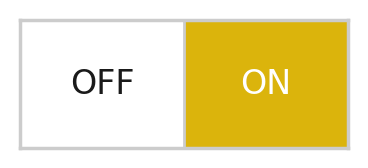

In [76]:
sns.set()
sns.set_style("whitegrid")
fig = palplot(bw_palette, ['OFF', 'ON'], ['k', 'w'])
savesvg('legend - on_off.svg', fig)

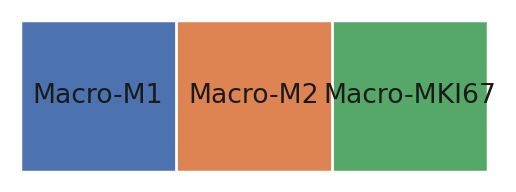

In [77]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot(sns.color_palette(COLORS), adata.obs["anno_clusters"].dtype.categories, size=1.0)
#savesvg('legend - GSE115978 - cell_type_colors.svg', fig)

In [459]:
def fetch_logo(regulon, base_url = BASE_URL):
    for elem in regulon.context:
        if elem.endswith('.png'):
            return '<img src="{}{}" style="max-height:124px;"></img>'.format(base_url, elem)
    return ""

In [460]:
df_regulons = pd.DataFrame(data=[list(map(op.attrgetter('name'), regulons)),
                                 list(map(len, regulons)),
                                 list(map(fetch_logo, regulons))], index=['name', 'count', 'logo']).T

In [461]:
MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', -1)
display(HTML(df_regulons.head().to_html(escape=False)))
pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

,name,count,logo
0,Ar(+),11,
1,Arid3a(+),111,
2,Arntl2(+),45,
3,Ascl2(+),18,
4,Atf1(+),445,


In [403]:
auc_mtx_=auc_mtx.loc[adata_.obs_names]

In [406]:
rss = regulon_specificity_scores(auc_mtx_, adata_.obs.anno_clusters)

In [407]:
rss.loc["Macro-M1"].sort_values( ascending=False).head(20)

Zmiz1(+)     0.580121
Irf8(+)      0.575856
Ep300(+)     0.570146
Chd2(+)      0.566434
Cebpz(+)     0.564067
Mef2a(+)     0.563589
Hcfc1(+)     0.561888
Elf4(+)      0.561222
Foxj2(+)     0.560832
Taf1(+)      0.558753
Kdm5a(+)     0.555948
Sp1(+)       0.554376
Mef2c(+)     0.552850
Mxd4(+)      0.551833
Bmyc(+)      0.549979
Brf1(+)      0.549738
Bclaf1(+)    0.548670
Tfeb(+)      0.547634
Ctcf(+)      0.547497
Sin3a(+)     0.547062
Name: Macro-M1, dtype: float64

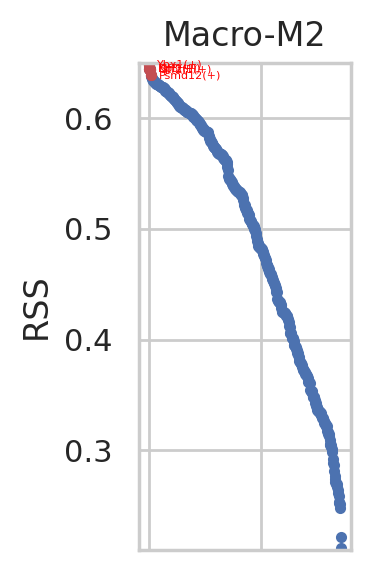

In [207]:
sns.set()
sns.set(style='whitegrid', font_scale=1)
fig, (ax1) = plt.subplots(1, 1, figsize=(2,3), dpi=100)
plot_rss(rss, 'Macro-M2', ax=ax1)
ax1.set_xlabel('')

plt.tight_layout()
savesvg('plots -M2- rss.svg', fig)

In [ ]:
sns.set()
sns.set(style='whitegrid', font_scale=1)
fig, (ax1) = plt.subplots(1, 1, figsize=(2,3), dpi=100)
plot_rss(rss, 'Macro-M1', ax=ax1)
ax1.set_xlabel('')
plot_rss(rss, 'Macro-M2', ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('')
plot_rss(rss, 'Macro-MKI67', ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('')

plt.tight_layout()
savesvg('plots -Macro- rss.svg', fig)

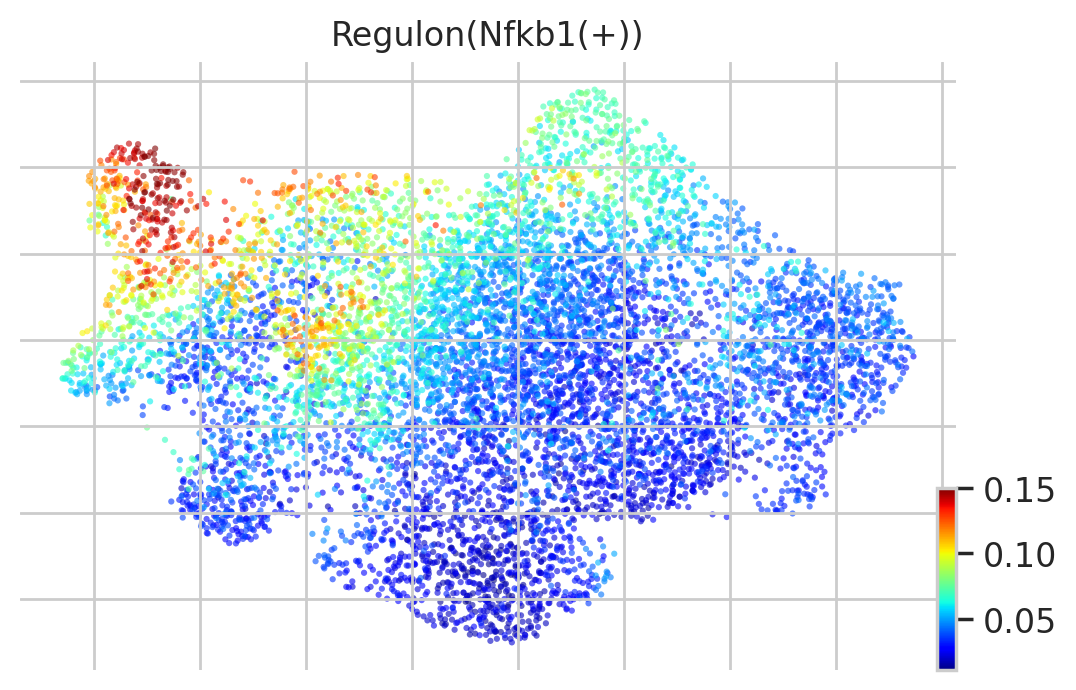

In [267]:
#overlap signature or gene expression in umap
color_name="Regulon(Nfkb1(+))"
scv.pl.scatter(adata,basis="umap",
               color=color_name, 
               alpha=0.6,size=20, color_map="jet",
               smooth=10, perc=[2, 98],ncols=4
              )#save=f"{color_name}_98_2.pdf")

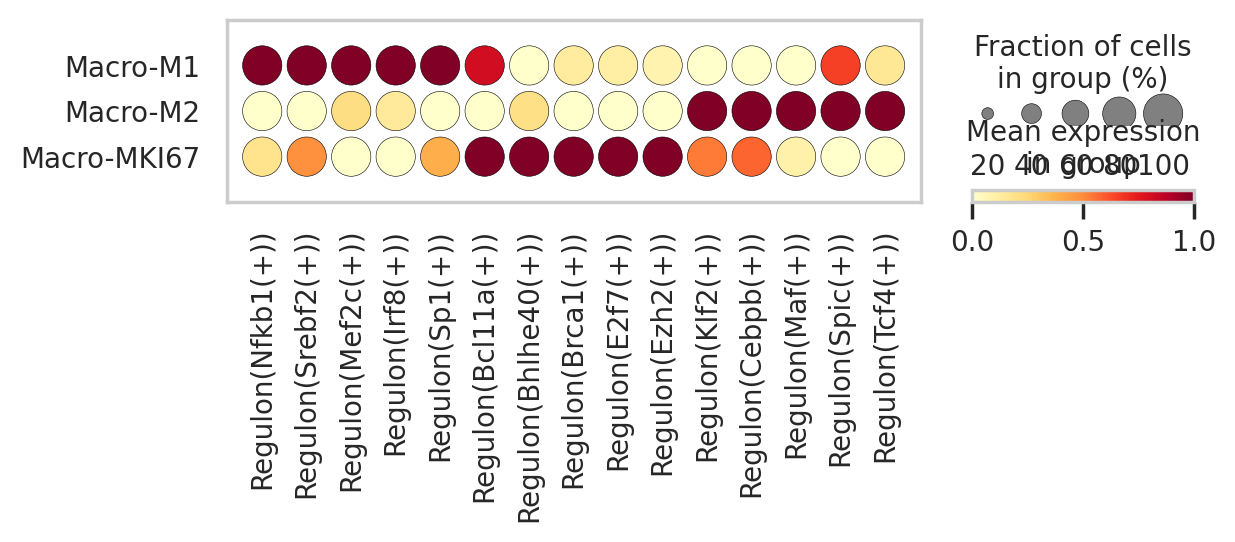

In [415]:
groupby="anno_clusters"
sc.tl.dendrogram(adata, groupby=groupby)
sc.pl.dotplot(adata, ["Regulon(Nfkb1(+))","Regulon(Srebf2(+))","Regulon(Mef2c(+))","Regulon(Irf8(+))","Regulon(Sp1(+))",
                      "Regulon(Bcl11a(+))",  "Regulon(Bhlhe40(+))","Regulon(Brca1(+))","Regulon(E2f7(+))","Regulon(Ezh2(+))",
                      "Regulon(Klf2(+))","Regulon(Cebpb(+))","Regulon(Maf(+))","Regulon(Spic(+))","Regulon(Tcf4(+))",], groupby=groupby,standard_scale="var", dendrogram=False,
              cmap="YlOrRd",figsize=(6.2,1.2),
             save=f"{project_ID}_regulons_{groupby}.pdf")

In [462]:
adata.write(f"{project_ID}_figures/{project_ID}_anno_dy_reg.h5ad")